# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Лавренов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
notmyteta = []
myteta = []
class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, debug=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.isdebug = debug
        self.sigmoid = np.vectorize(lambda x: 1.0 / (1.0 + np.exp(-x)))
        if self.isdebug:
            self.debug = []
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.teta = np.random.normal(loc=0.05, size=X.shape[1] + 1, scale=0.1) 
        
        self.partial_fit(X, y)
        return self
    def __los(self, X, y):
        
        sg = self.sigmoid(np.dot(X, self.teta))
        return np.mean(-y * np.log(sg) - (1 - y) * np.log(1 - sg))
        #return np.sum(np.log(1.0 + np.exp((- y) * np.dot(X, self.teta.T))))
        
    def __grad(self, X, y):
        
        sg = self.sigmoid(np.dot(X, self.teta)) 

        return (sg - y).T * X + 2 / self.C * self.teta
          
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        
        train = np.c_[X, np.ones(X.shape[0])]
        train = np.c_[train, y]
        
        batch_count = int(np.sqrt(X.shape[0]))
        batch_length = int(X.shape[0] / batch_count)
        iteration = 1
        bestlos = -1

        for iteration in xrange(self.max_epoch):

            train = np.random.permutation(train)
                
            for i in range(batch_count):
                batch = train[i * batch_length : (i + 1) * batch_length]
               
                grad = self.__grad(batch[:,:-1], batch[:,-1:].T)
                
                self.teta = self.teta - self.alpha * np.mean(grad, axis=0)
                
            if self.isdebug:
                currlos = self.__los(train[:,:-1], train[:,-1:].T)
                    
                self.debug.append(currlos) 
               
        if self.isdebug:     
            self.debug = np.array(self.debug)
        return self

        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        train = np.c_[X, np.ones(X.shape[0])]
        return np.sign(np.dot(train , self.teta.T))
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        train = np.c_[X, np.ones(X.shape[0])]
        return self.sigmoid(np.dot(train , self.teta.T))

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

(400L, 2L) (400L,)


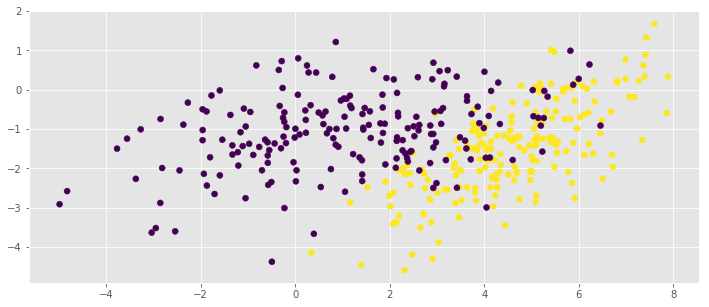

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)
print X.shape, y.shape

[ 1.55848171 -1.80317233 -7.91611876]


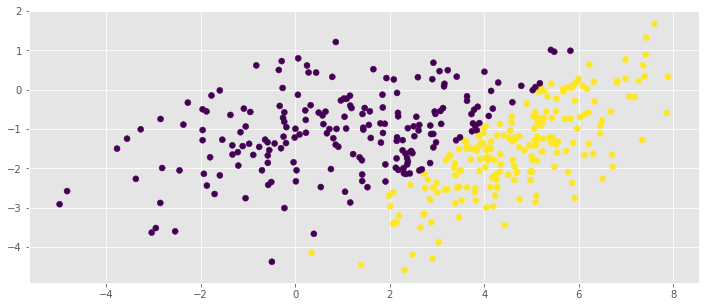

In [6]:
model = MySGDClassifier(alpha=0.8, C=1000, max_epoch=30)
model.fit(X, y)
ypred = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=ypred)
print model.teta

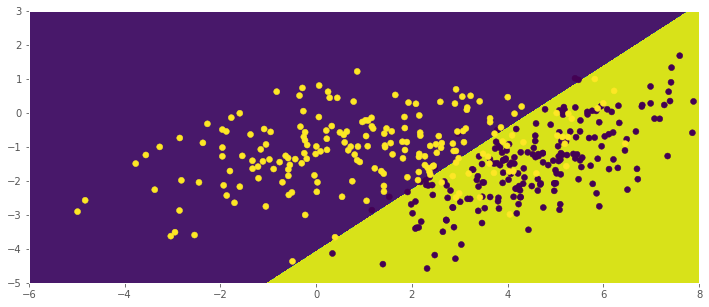

In [7]:
model = MySGDClassifier(alpha=0.8, C=1000, max_epoch=30)
model.fit(X, y)

h = 0.01
x_min, x_max = -6, 8
y_min, y_max = -5, 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T
/
ypred = model.predict(xy)
ypred = ypred.reshape(xx.shape)

plt.contourf(xx, yy, ypred)
plt.scatter(X[:, 0], X[:, 1], c=(-y))

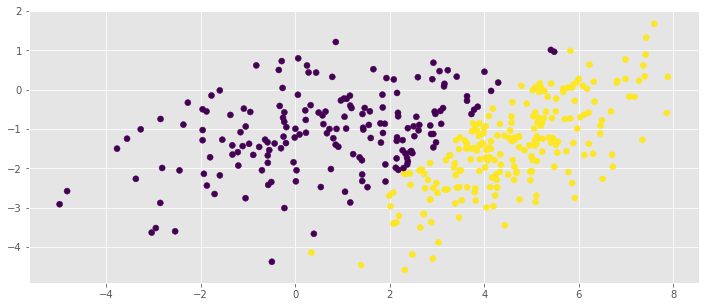

In [8]:
## Your Code Here

from sklearn.linear_model import LogisticRegression

sklr = LogisticRegression()
sklr.fit(X, y)
skypred = sklr.predict(X)
plt.scatter(X[:,0], X[:,1], c=skypred)

## Анализ сходимости (2 балл)

Для следующих заданий используйте датасет ниже

In [44]:
from sklearn.datasets import make_classification

In [45]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

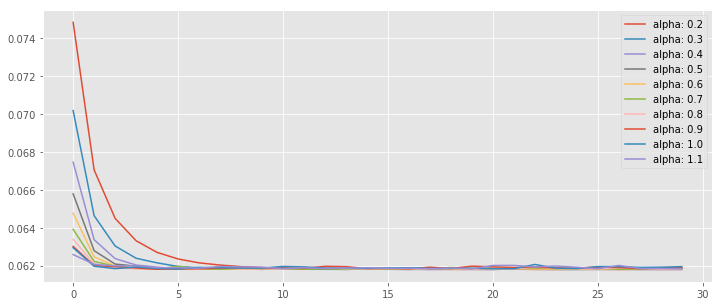

In [49]:
for alpha in np.arange(0.2, 1.2, 0.1):
    testalpha = MySGDClassifier(alpha=alpha, C=1000, max_epoch=30, debug=True)
    testalpha.fit(X, y)
    plt.plot(np.arange(testalpha.debug.shape[0]), testalpha.debug, label='alpha: {}'.format(alpha))

plt.legend()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [58]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = 'trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [59]:
df_data.shape

(500000, 45)

In [60]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [61]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [62]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [63]:
## Youd Code Here
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cnt_uniq_cards = np.concatenate(
    (df_data['player_hero_card_id'].unique(), 
     df_data['opponent_hero_card_id'].unique())
)

le = LabelEncoder()
le.fit(cnt_uniq_cards)
del cnt_uniq_cards
ohe = OneHotEncoder()
ohe.fit(np.arange(le.classes_.shape[0]).reshape(-1,1))
print 'There are {} unique hero card'.format(le.classes_.shape[0])

Count 9 unique hero card


In [64]:
pl_hcid_ohe = ohe.transform(
    le.transform(df_data['player_hero_card_id']).reshape(-1,1)
).toarray()
opp_hcid_ohe = ohe.transform(
    le.transform(df_data['opponent_hero_card_id']).reshape(-1,1)
).toarray()
for i in xrange(pl_hcid_ohe.shape[1]):
    df_data['player_hcid_onehot_%d' % i] = pl_hcid_ohe[:, i]
    df_data['opponent_hcid_onehot_%d' % i] = opp_hcid_ohe[:, i]
df_data = df_data.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

del pl_hcid_ohe, opp_hcid_ohe

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [65]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [66]:
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

In [77]:
sclaer = StandardScaler()
model = MySGDClassifier(alpha=0.8, max_epoch=1, C=100)

scale_model = Pipeline([('scaler', sclaer), ('model', model)])
scale_model.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=100, alpha=0.8, debug=None, max_epoch=1))])

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [78]:
## Your Code Here
df_list = []
for chunk in range(5,8):
    filepath = 'testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)

df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

pl_hcid_ohe = ohe.transform(
    le.transform(df_data_test['player_hero_card_id']).reshape(-1,1)
).toarray()
opp_hcid_ohe = ohe.transform(
    le.transform(df_data_test['opponent_hero_card_id']).reshape(-1,1)
).toarray()
for i in xrange(pl_hcid_ohe.shape[1]):
    df_data_test['player_hcid_onehot_%d' % i] = pl_hcid_ohe[:, i]
    df_data_test['opponent_hcid_onehot_%d' % i] = opp_hcid_ohe[:, i]
df_data_test = df_data_test.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

del pl_hcid_ohe, opp_hcid_ohe

In [79]:
from sklearn.metrics import roc_auc_score

y = np.loadtxt('deprecated_testLabels.txt')
X = df_data_test.iloc[:,1:].values

y_hat = scale_model.predict_proba(X)

print 'ROC_AUC:', roc_auc_score(y, y_hat)

ROC_AUC: 0.795914512524
